In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('health_data.csv')
data.head()

,age,restbps,chol,category
0,26,109,243,0
1,27,106,156,0
2,28,107,225,0
3,27,105,277,0
4,30,96,221,0


In [3]:
#first, lets try a bayes classifier with the class conditional densities assumed to be Gaussian. There are two categories, 0 and 1.
X = data.to_numpy()[:, :3]
Y = data.to_numpy()[:, 3]


split = 0.8 #using 70:30 split, random each time
train_samples = np.random.choice(X.shape[0], int(split*X.shape[0]))
test_samples = np.array([i for i in range(X.shape[0]) if i not in list(train_samples)])

X_train = X[[train_samples]]
Y_train = Y[[train_samples]]

X_test = X[[test_samples]]
Y_test = Y[[test_samples]]


X_0 = X_train[Y_train == 0]
X_1 = X_train[Y_train == 1]

#X_0 = data[data['category'] == 0].to_numpy()[:, :3]
#X_1 = data[data['category'] == 1].to_numpy()[:, :3]
#how to split data into test and train?


C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

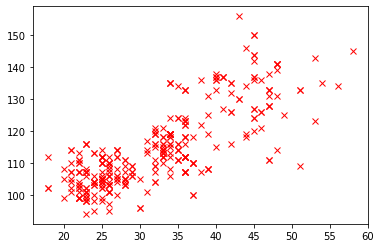

In [4]:
plt.plot(X_0[:,0], X_0[:,1], 'rx') #cholestrol vs age
#clearly they are not independent features

In [5]:
#estimating mean, variance for class 0
#maximum likelihood estimate

u0 = np.mean(X_0, axis=0) 
s0 = (X_0 - u0).T @ (X_0 - u0)/X_0.shape[0]
s0 = np.linalg.inv(s0)

#for class 1
u1 = np.mean(X_1, axis = 0)
s1 = (X_1 - u1).T @ (X_1 - u1)/X_1.shape[0]
s1 = np.linalg.inv(s1) #inverse of cov matrix

In [6]:
#decision boundary
p0 = X_0.shape[0]; p1 = X_1.shape[0]
p0 = p0/(p0 + p1); p1 = 1 - p0;
print('p0 = {}, p1 = {}'.format(p0, p1))
#priors chosen on basis of frequency of occurence in training data.
p = np.log(p0/p1)

s = 0.5*np.log(np.linalg.det(s0)/np.linalg.det(s1))
def g1(x):
    y = p + s -0.5*((x - u0) @ s0 @ (x-u0).T - (x - u1) @ s1 @ (x - u1))
    
    if (y > 0): 
        return 0
    else:return 1

p0 = 0.5803571428571429, p1 = 0.4196428571428571


In [7]:
#computing accuracy.
C = np.zeros((2,2)) #[[]]
for i in range((X_test.shape[0])):
    y_pred = g1(X_test[i])
    C[y_pred, Y_test[i]] += 1
        

In [8]:
acc = (C[0,0] + C[1,1])/np.sum(C)
print(acc)
# nearly 85 % accuracy obtained, in almost every case, no matter how the data is split.

0.8478964401294499


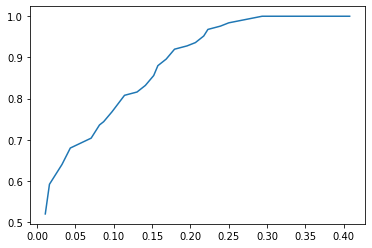

In [9]:
#Now, we will vary the priors, and plot the ROC curve.
TP = []
FP = []
for p0 in np.linspace(0.01,0.99,25):
    p = np.log(p0/(1 - p0))
    def g2(x):
        y = p + s -0.5*((x - u0) @ s0 @ (x-u0).T - (x - u1) @ s1 @ (x - u1))
    
        if (y > 0): 
            return 0
        else:return 1
    C = np.zeros((2,2))
    for i in range((X_test.shape[0])):
        y_pred = g2(X_test[i])
        C[y_pred, Y_test[i]] += 1
    
    tpr = C[1,1]/(C[1,1] + C[0,1])
    fpr = C[1,0]/(C[1,0] + C[0,0])
    TP.append(tpr)
    FP.append(fpr)

plt.plot(FP, TP, '-')